<a href="https://colab.research.google.com/github/yousefosama97/Data_Science/blob/main/Sentiment_Analysis_on_Financial_News_Headlines_using_DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [2]:
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score

In [5]:
# !pip install datasets
from datasets import Dataset

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig


In [7]:
from IPython.display import clear_output

In [8]:
# !pip install fastai==1.0.58
import fastai
from fastai import *
# from fastai.text import BaseTokenizer

In [9]:
# Set random seeds for reproducibility
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 123
seed_all(seed)


In [11]:
# Data loading and preprocessing
raw = pd.read_csv('FinancialNewsHeadline.csv', encoding='latin-1', names=['label', 'News_Headline'])
raw['label'].replace({'neutral': 'Neutral', 'positive': 'Positive', 'negative': 'Negative'}, inplace=True)

# Prepare numerical labels
raw2 = raw.copy()
raw2['label'].replace({'Neutral': 0, 'Positive': 1, 'Negative': 2}, inplace=True)
raw2 = raw2[['News_Headline', 'label']]

# Split data into train, validation, and test sets
df_train, df_test = train_test_split(raw2, stratify=raw2['label'], test_size=0.1, random_state=seed)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=seed)

# print(f"Training set size: {len(df_train)}")
# print(f"Validation set size: {len(df_val)}")
# print(f"Test set size: {len(df_test)}")


In [12]:
raw.head()

,label,News_Headline
0,Neutral,"According to Gran , the company has no plans t..."
1,Neutral,Technopolis plans to develop in stages an area...
2,Negative,The international electronic industry company ...
3,Positive,With the new production plant the company woul...
4,Positive,According to the company 's updated strategy f...


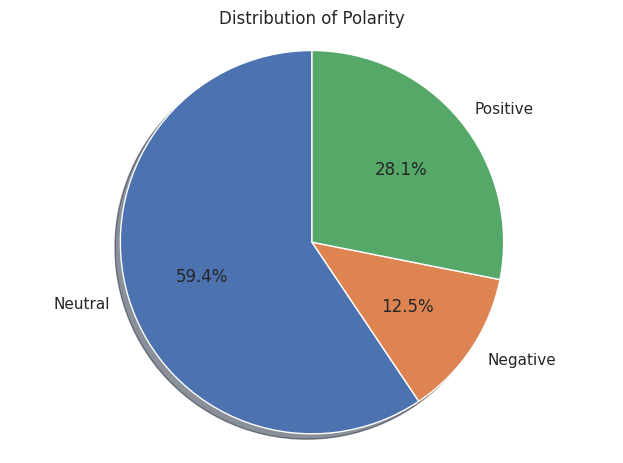

In [13]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Neutral', 'Negative', 'Positive'
total = raw['label'].count()
Neutral = raw['label'][raw['label'] == 'Neutral'].count() / total
Negative = raw['label'][raw['label'] == 'Negative'].count() / total
Positive = raw['label'][raw['label'] == 'Positive'].count() / total
sizes = [Neutral, Negative, Positive]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Polarity', fontsize=12)
plt.set_cmap("gist_rainbow")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of News')

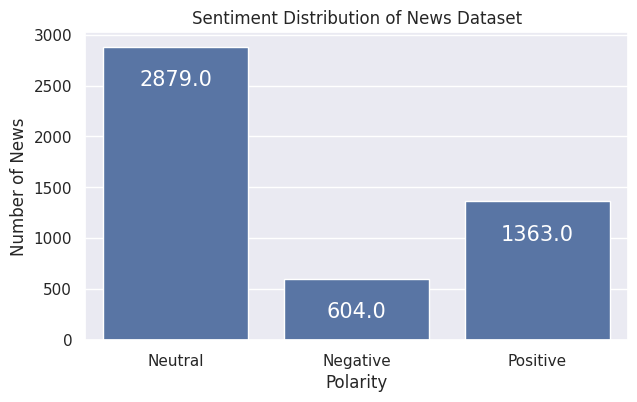

In [15]:
plt.figure(figsize = (7, 4))
sns.set(style='darkgrid')

ax = sns.countplot(x='label', data = raw)
# Increase information on the figure
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=15)
plt.title('Sentiment Distribution of News Dataset')
plt.xlabel('Polarity')
plt.ylabel('Number of News')


In [16]:
def frequency_length(df, column_name, figsize = (10, 6)):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    clear_output()
    sequence_token_lengths = []

    for headline in df[column_name]:
        encoded_headline = tokenizer.encode(headline, add_special_tokens=True)
        # record the length of the encoded review
        sequence_token_lengths.append(len(encoded_headline))

    # Get the percentage of headlines with length > 512
    len_512_plus = [head_len for head_len in sequence_token_lengths if head_len > 512]
    percent = (len(len_512_plus)/len(sequence_token_lengths)) * 100

    print('Facts:')
    print("1. Number of Sequences With Greater Than 512 Tokens: {}".format(len(len_512_plus)))
    print("2. Maximum Sequence Length: {} Tokens".format(max(sequence_token_lengths)))
    print("3. Average Sequence Length: {} Tokens".format(np.average(sequence_token_lengths).round(1)))

    # Configure the plot size
    plt.figure(figsize = figsize)
    sns.set(style='darkgrid')
    # Plot the result
    sns.displot(sequence_token_lengths, kde = False, rug = False)
    plt.title("Distribution of Sequences' Lengths")
    plt.xlabel("Sequences' Length")
    plt.ylabel('Number of Sequences')

Facts:
1. Number of Sequences With Greater Than 512 Tokens: 0
2. Maximum Sequence Length: 150 Tokens
3. Average Sequence Length: 30.6 Tokens


<Figure size 1000x600 with 0 Axes>

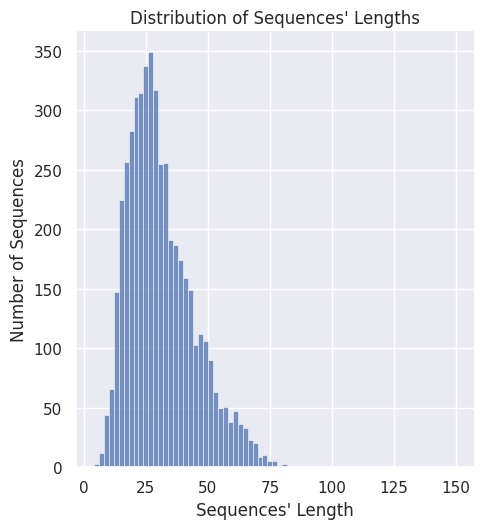

In [25]:
frequency_length(raw, 'News_Headline')

In [35]:
from transformers import DistilBertTokenizer

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Take a single example from your raw dataset
single_example = raw.iloc[0]  # Let's take the first row as an example

# Tokenize the text of the example
tokenized_output = tokenizer(
    single_example['News_Headline'],
    padding='max_length',  # Ensures that sequences are padded to the max_length
    truncation=True,       # Ensures that sequences are truncated if they exceed max_length
    max_length=30,        # Sets a max length of 128 tokens
    return_tensors='pt'    # Returns PyTorch tensors
)

# Print the tokenized output


In [38]:
# print("Tokenized Output:", tokenized_output)
print("\nInput IDs:", tokenized_output['input_ids'])
print("\nAttention Mask:", tokenized_output['attention_mask'])
# Decode tokens back to text to see the result
decoded_text = tokenizer.decode(tokenized_output['input_ids'][0], skip_special_tokens=True)
print("\nDecoded Text from Token IDs:", decoded_text)


Input IDs: tensor([[  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,  3488,
          2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,  2008,  2003,
          2073,  1996,  2194,  2003,  3652,  1012,   102,     0,     0,     0]])

Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0]])

Decoded Text from Token IDs: according to gran, the company has no plans to move all production to russia, although that is where the company is growing.


In [31]:
# Strip the padding from the input sequence
tokens_without_padding = [token for token, mask in zip(tokenized_output['input_ids'][0], tokenized_output['attention_mask'][0]) if mask == 1]
decoded_text_without_padding = tokenizer.decode(tokens_without_padding, skip_special_tokens=True)

print("\nDecoded Text without Padding:", decoded_text_without_padding)



Decoded Text without Padding: according to gran, the company has no plans to move all production to russia, although that is where the company is growing.


# Tokenization

In [13]:
# Initialize DistilBERT model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples['News_Headline'],
        padding='max_length',
        truncation=True,
        max_length=250  # Reduced from 512 for efficiency
    )

# Apply tokenization
dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)
dataset_test = dataset_test.map(tokenize_function, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
dataset_train.set_format(type='torch', columns=columns)
dataset_val.set_format(type='torch', columns=columns)
dataset_test.set_format(type='torch', columns=columns)

# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score': f1_score(labels, predictions, average='weighted')}

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [60]:
dataset_train

Dataset({
    features: ['News_Headline', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 3924
})

# Feature Extraction approach

In [71]:
from transformers import DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load pre-trained DistilBERT model without classification head
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Function to extract features
def extract_features(dataset, model, tokenizer, device='cpu'):
    model.to(device)
    model.eval()  # Set model to evaluation mode

    features = []
    labels = []

    for example in dataset:
        # Access tokenized input using 'input_ids' and 'attention_mask'
        inputs = {
            'input_ids': example['input_ids'].unsqueeze(0).to(device), # Add batch dimension
            'attention_mask': example['attention_mask'].unsqueeze(0).to(device) # Add batch dimension
        }

        with torch.no_grad():
            outputs = model(**inputs)
            # Use the [CLS] token embedding (first token) as the feature
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(cls_embedding)
        labels.append(example['label'])

    features = np.vstack(features)
    labels = np.array(labels)
    return features, labels

# Extract features for train, validation, and test sets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_features, train_labels = extract_features(dataset_train, distilbert_model, tokenizer, device)
val_features, val_labels = extract_features(dataset_val, distilbert_model, tokenizer, device)
test_features, test_labels = extract_features(dataset_test, distilbert_model, tokenizer, device)

# Train a logistic regression classifier on the extracted features
clf = LogisticRegression(max_iter=1000, random_state=seed)
clf.fit(train_features, train_labels)

# Evaluate on the validation set
val_predictions = clf.predict(val_features)
print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=['Neutral', 'Positive', 'Negative']))

# Evaluate on the test set
test_predictions = clf.predict(test_features)
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Neutral', 'Positive', 'Negative']))

Validation Classification Report:
              precision    recall  f1-score   support

     Neutral       0.86      0.87      0.86       260
    Positive       0.70      0.70      0.70       123
    Negative       0.75      0.70      0.72        54

    accuracy                           0.80       437
   macro avg       0.77      0.76      0.76       437
weighted avg       0.80      0.80      0.80       437

Test Classification Report:
              precision    recall  f1-score   support

     Neutral       0.87      0.88      0.88       288
    Positive       0.76      0.70      0.73       136
    Negative       0.68      0.75      0.71        61

    accuracy                           0.81       485
   macro avg       0.77      0.78      0.77       485
weighted avg       0.81      0.81      0.81       485



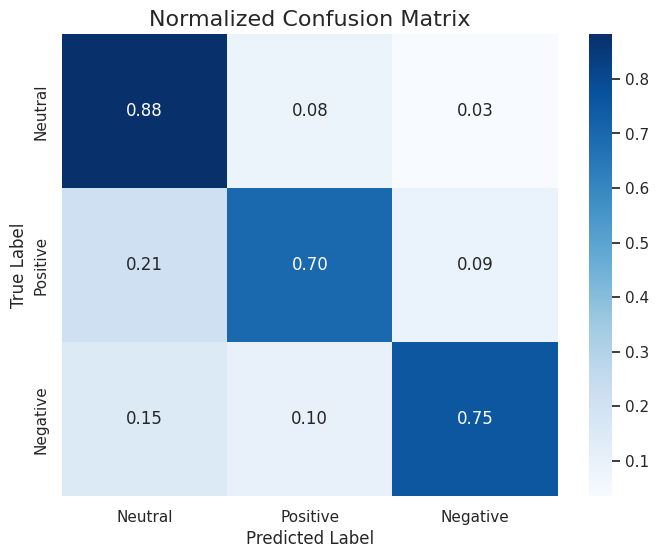

In [74]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the test set
cm = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by dividing each row by its sum
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


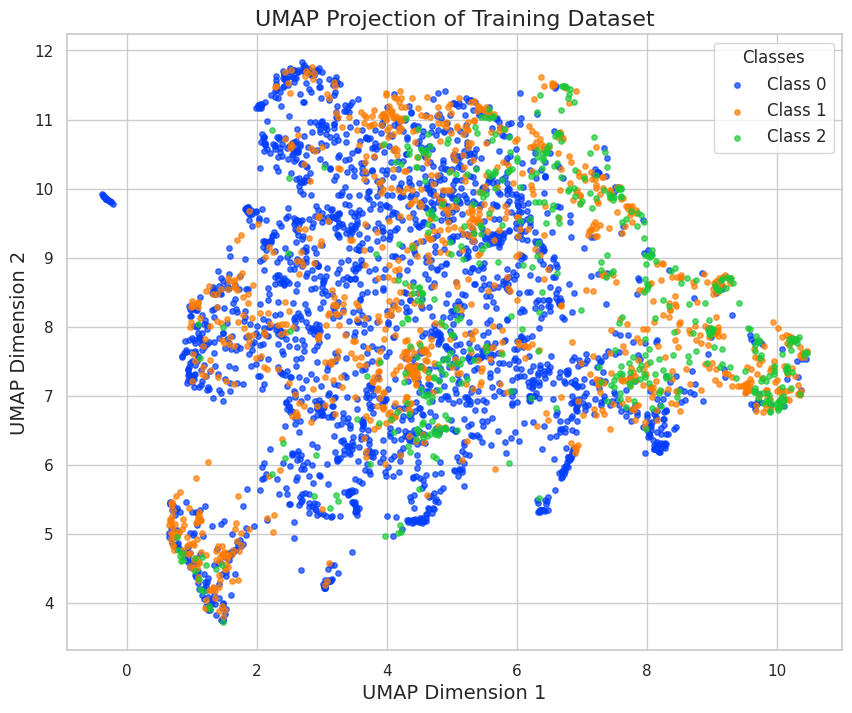

In [73]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for visualization
sns.set_palette("bright")
sns.set(style="whitegrid")

# Apply UMAP to reduce features to 2D for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
train_features_2d = reducer.fit_transform(train_features)

# Create a scatter plot for visualization
plt.figure(figsize=(10, 8))
unique_labels = np.unique(train_labels)

# Assign unique colors to each label
colors = sns.color_palette("bright", len(unique_labels))

for label, color in zip(unique_labels, colors):
    indices = train_labels == label
    plt.scatter(
        train_features_2d[indices, 0],
        train_features_2d[indices, 1],
        label=f"Class {label}",
        alpha=0.7,
        s=15,
        color=color,
    )

plt.title("UMAP Projection of Training Dataset", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.legend(title="Classes", fontsize=12)
plt.show()


# Fine Tunining Approach

In [14]:
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_val = dataset_val.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_test = dataset_test.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length' , max_length=512), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

### Training

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score' : f1_score(predictions, labels, average='micro')}


In [17]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',            # Directory to save the model and logs
    evaluation_strategy='epoch',       # Evaluate after each epoch
    learning_rate=2e-5,                # Learning rate
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=8,      # Batch size for evaluation
    num_train_epochs=5,                # Number of epochs
    weight_decay=0.01,                 # Weight decay for regularization
    logging_dir='./logs',              # Directory for logs
    logging_steps=500,                 # Log every 500 steps
    save_strategy='epoch',             # Save checkpoint after each epoch
    load_best_model_at_end=True,       # Load the best model at the end of training
    metric_for_best_model='f1_score', # Metric for selecting the best model
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                       # Model to train
    args=training_args,                # Training arguments
    train_dataset=dataset_train,       # Training dataset
    eval_dataset=dataset_val,          # Validation dataset
    compute_metrics=compute_metrics    # Metrics for evaluation
)

# Train the model
trainer.train()




wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.359778,0.862700
2,0.534400,0.415883,0.869565
3,0.284800,0.566834,0.860412
4,0.164700,0.656643,0.867277
5,0.092700,0.696196,0.864989


TrainOutput(global_step=2455, training_loss=0.23061277463334157, metrics={'train_runtime': 1047.4275, 'train_samples_per_second': 18.732, 'train_steps_per_second': 2.344, 'total_flos': 2599056711290880.0, 'train_loss': 0.23061277463334157, 'epoch': 5.0})

In [18]:
# Evaluate the model on the test set
test_results = trainer.evaluate(dataset_test)
print(test_results)

{'eval_loss': 0.4257622957229614, 'eval_f1_score': 0.8762886597938144, 'eval_runtime': 7.2922, 'eval_samples_per_second': 66.509, 'eval_steps_per_second': 8.365, 'epoch': 5.0}


In [19]:
# Evaluate the model on the test set
test_results = trainer.evaluate(dataset_val)
print(test_results)

{'eval_loss': 0.4158831536769867, 'eval_f1_score': 0.8695652173913043, 'eval_runtime': 6.4825, 'eval_samples_per_second': 67.412, 'eval_steps_per_second': 8.484, 'epoch': 5.0}


In [7]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.3512435853481293,
 'test_f1_score': 0.8582586390842919,
 'test_runtime': 139.6624,
 'test_samples_per_second': 3.473,
 'test_steps_per_second': 0.437}

In [8]:
trainer.save_model('BERT_fine_tuned_1')

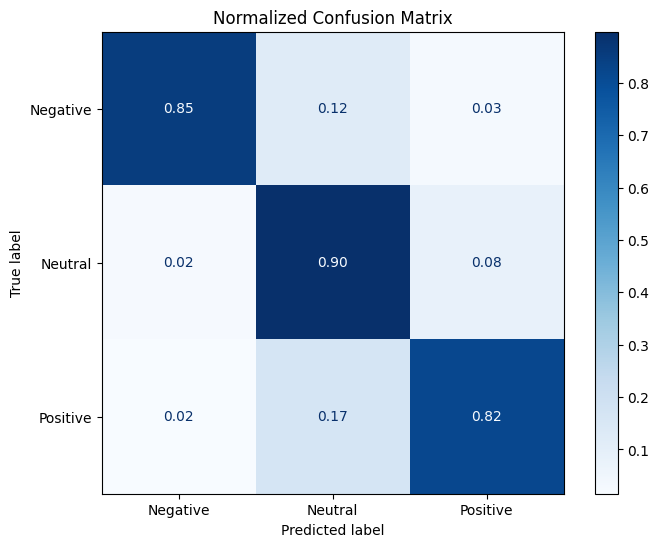

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Raw confusion matrix data
conf_matrix = np.array([
    [98, 14, 3],
    [13, 492, 43],
    [4, 43, 212]
])

# Normalize the confusion matrix by rows (true labels)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define labels
labels = ["Negative", "Neutral", "Positive"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_conf_matrix, display_labels=labels)
disp.plot(cmap="Blues", ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()
